In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             roc_auc_score, accuracy_score, precision_recall_curve, 
                             precision_score, recall_score, auc, f1_score, make_scorer, auc)
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

import xgboost as xgb

from scipy import interp


In [5]:
file_name = 'dataset.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_name)
# Create a copy of the original DataFrame
df_copy = df.copy()

In [6]:
# Transform debt_ratio into % and round
df_copy['debt_ratio'] = round(df_copy['debt_ratio'] * 100)

# Drop rows with missing values in the 'nr_dependents' column
df_copy_dropped = df_copy.dropna(subset=['nr_dependents'])

# Drop rows with missing values in the 'monthly_income' column
df_copy_dropped = df_copy.dropna(subset=['monthly_income'])


# remove monthly payment outliers
q1,q3 = np.percentile(df_copy_dropped.monthly_income , [25, 75])
iqr = q3-q1
iqr1_5 = q3 + 1.5*iqr
iqr1_5
outliers = df_copy_dropped[df_copy_dropped["monthly_income"] >= iqr1_5]
df_copy_dropped.drop(index=outliers.index, inplace=True)
df_copy_dropped


df_copy_dropped['monthly_income'] = df_copy_dropped['monthly_income'].round(2)
# Display the first few rows of the updated DataFrame
print("\nUpdated DataFrame:")

df_copy_dropped.describe()


Updated DataFrame:


C:\Users\inesm\AppData\Local\Temp\ipykernel_7848\2596776134.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_dropped.drop(index=outliers.index, inplace=True)
C:\Users\inesm\AppData\Local\Temp\ipykernel_7848\2596776134.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_dropped['monthly_income'] = df_copy_dropped['monthly_income'].round(2)


,monthly_income,debt_ratio,nr_dependents,credit_balances_dividedby_limits,nr_open_credit_lines_and_loans,nr_real_estate_loans,nr_times_30_59_days_past_due,nr_times_60_89_days_past_due,nr_times_90plus_days_past_due,serious_delinquency
count,115390.000000,1.153900e+05,115390.000000,115390.000000,115390.000000,115390.000000,115390.000000,115390.000000,115390.000000,115390.000000
mean,5761.661461,2.771290e+03,0.833902,5.117912,8.633928,1.010443,0.386307,0.192894,0.218286,0.070379
std,3282.542436,4.332917e+04,1.137264,206.346372,5.089336,1.072651,3.557760,3.507479,3.525184,0.255785
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3325.000000,1.500000e+01,0.000000,0.034779,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5200.000000,3.000000e+01,0.000000,0.178514,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,7809.000000,4.900000e+01,1.000000,0.585658,11.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,15520.000000,6.110650e+06,20.000000,29110.000000,58.000000,54.000000,98.000000,98.000000,98.000000,1.000000


# data for applying the models

In [7]:
dataset = df_copy_dropped.drop(['nr_dependents'], axis=1)
# 'monthly_income','', 'nr_open_credit_lines_and_loans','nr_real_estate_loans','nr_times_30_59_days_past_due','nr_times_60_89_days_past_due'

# Logistic regression with best results achieved

Cross-validation scores: [0.40298879 0.39322719 0.4013622  0.4028777  0.40071924]
Mean cross-validation score: 0.4002350241656615
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     26808
           1       0.34      0.50      0.40      2040

    accuracy                           0.89     28848
   macro avg       0.65      0.71      0.67     28848
weighted avg       0.92      0.89      0.90     28848

Confusion Matrix before threshold improvement:
[[24788  2020]
 [ 1016  1024]]
Accuracy Score:
0.8947587354409318
Best threshold: 0.59
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     26808
           1       0.40      0.43      0.42      2040

    accuracy                           0.91     28848
   macro avg       0.68      0.69      0.68     28848
weighted avg       0.92      0.91      0.92     28848

Confusion Matr

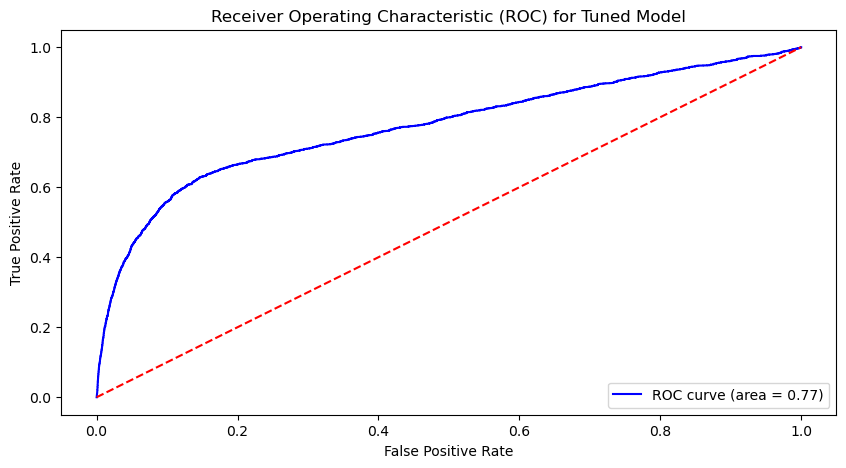

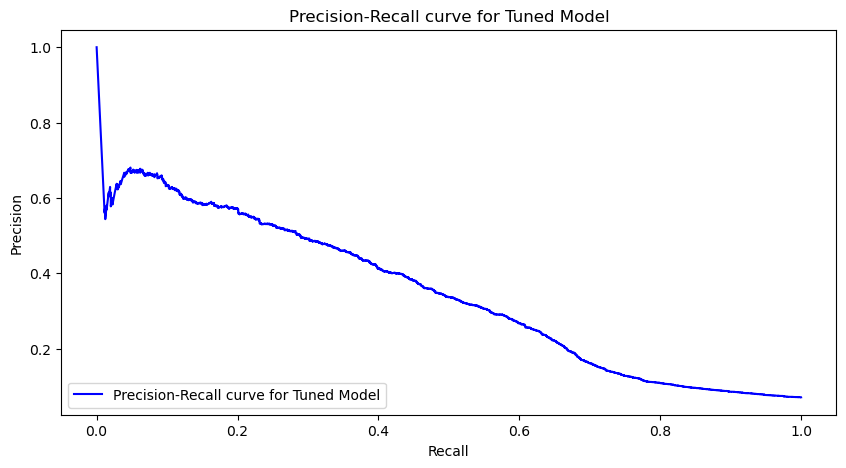

Final model score: 0.8947587354409318


In [87]:
# Drop the target column from X
X = dataset.drop('serious_delinquency', axis=1)
y = dataset['serious_delinquency']

# Initialize the pipeline with SMOTE and EditedNearestNeighbours and StandardScaler
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.4)),  # Increase positive class
    ('enn', EditedNearestNeighbours()),  # Decrease negative class
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Cross-validation with F1 scoring
f1_scorer = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(pipeline, X, y, cv=skf, scoring=f1_scorer)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Predictions on the test data
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Model evaluation before threshold adjustment
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix before threshold improvement:')
print(confusion_matrix(y_test, y_pred))

print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

# Simulate prediction probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the best threshold based on F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'Best threshold: {best_threshold:.2f}')

# Apply the custom threshold to get the predicted classes
y_pred_custom = (y_scores >= best_threshold).astype(int)

# Evaluate the model with the custom threshold
print('Classification Report with Custom Threshold:')
print(classification_report(y_test, y_pred_custom))

print('Confusion Matrix with Custom Threshold:')
print(confusion_matrix(y_test, y_pred_custom))

print('Accuracy Score with Custom Threshold:')
print(accuracy_score(y_test, y_pred_custom))

# ROC and Precision-Recall curves to evaluate the model
fpr_best, tpr_best, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 5))
plt.plot(fpr_best, tpr_best, color='blue', label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Tuned Model')
plt.legend(loc='lower right')
plt.show()

precision_best, recall_best, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 5))
plt.plot(recall_best, precision_best, color='blue', label='Precision-Recall curve for Tuned Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Tuned Model')
plt.legend(loc='lower left')
plt.show()

print('Final model score:', pipeline.score(X_test, y_test))


# Support Vector Machines (SVM)

In [6]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [7]:
# Standardize features
ss = StandardScaler()
X_train_res = ss.fit_transform(X_train_res)
X_test = ss.transform(X_test)


C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [8]:


# Initialize SVM model
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=0)

# Fit the model on the resampled training data
svm_model.fit(X_train_res, y_train_res)


SVC(class_weight='balanced', probability=True, random_state=0)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     27958
           1       0.27      0.47      0.34      2110

    accuracy                           0.87     30068
   macro avg       0.61      0.69      0.64     30068
weighted avg       0.91      0.87      0.89     30068

Confusion Matrix with Tuned Model:
[[25314  2644]
 [ 1127   983]]
Accuracy Score with Tuned Model:
0.8745842756418785


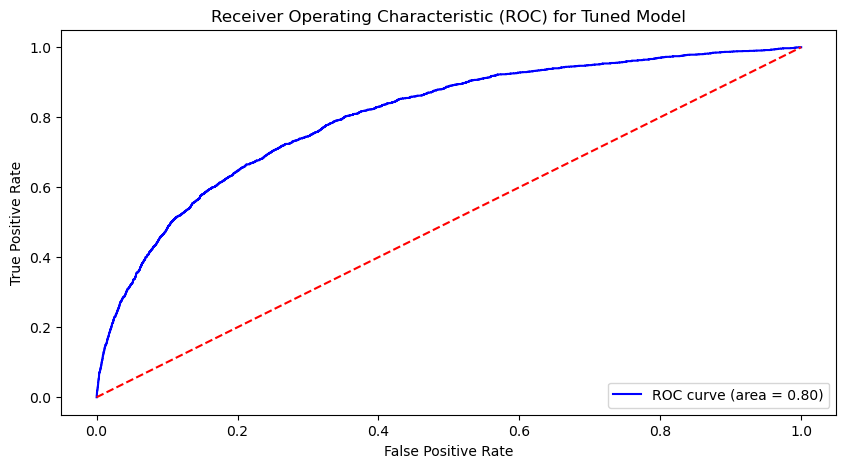

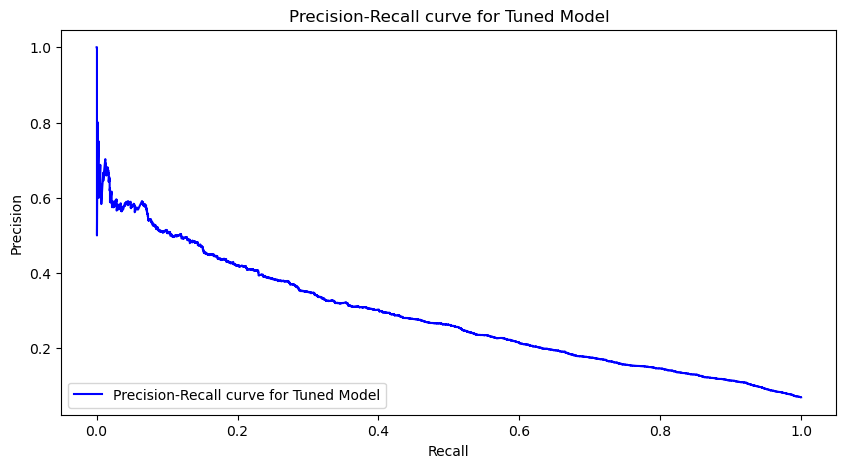

In [14]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Standardize features using StandardScaler
ss = StandardScaler()
X_train_res = ss.fit_transform(X_train_res)
X_test = ss.transform(X_test)

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y_train_res)/sum(y_train_res == 1), random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)

print("Best parameters found: ", grid_search.best_params_)

# Train the best model
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train_res, y_train_res)

# Predictions with the best model
y_pred_best = best_xgb_model.predict(X_test)
y_scores_best = best_xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_best))

print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_best))

print('Accuracy Score with Tuned Model:')
print(accuracy_score(y_test, y_pred_best))

# ROC and Precision-Recall curves for the tuned model
fpr_best, tpr_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 5))
plt.plot(fpr_best, tpr_best, color='blue', label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Tuned Model')
plt.legend(loc='lower right')
plt.show()

precision_best, recall_best, _ = precision_recall_curve(y_test, y_scores_best)

plt.figure(figsize=(10, 5))
plt.plot(recall_best, precision_best, color='blue', label='Precision-Recall curve for Tuned Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Tuned Model')
plt.legend(loc='lower left')
plt.show()


# NEW ATTEMPT

In [85]:
train_data = df_copy_dropped

train_col = train_data.columns[:-1]
target_col = train_data.columns[-1]

inputs = train_data[train_col]
target = train_data[target_col]

In [106]:
def train_and_evaluateRF(train_in, train_targets, val_in, val_targets, **params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(train_in, train_targets)
    train_acc = accuracy_score(train_targets, model.predict(train_in))
    val_predictions = model.predict(val_in) #     
    val_acc = accuracy_score(val_targets, val_predictions)
    return model, train_acc, val_acc, val_predictions, val_targets

In [63]:
def train_and_evaluateLR(train_in, train_targets, val_in, val_targets, **params):
    model = LogisticRegression(random_state=42, n_jobs=-1, **params)
    model.fit(train_in, train_targets)
    train_acc = accuracy_score(train_targets, model.predict(train_in))
    val_acc = accuracy_score(val_targets, model.predict(val_in))
    return model, train_acc, val_acc

In [64]:
kfold = KFold(n_splits=10)

In [107]:
print("This Is Random Forest Classifier")
def test_and_showRF(inputs, **params):
    modelsRF = []
    trainRF = []
    valRF = []
    all_val_predictions = [] #
    all_val_targets = [] #
    
    for train_idxs, val_idxs in kfold.split(inputs):
        X_train, train_targets = inputs.iloc[train_idxs], target.iloc[train_idxs]
        X_val, val_targets = inputs.iloc[val_idxs], target.iloc[val_idxs]
        model, train_acc, val_acc, val_predictions, val_targets = train_and_evaluateRF(X_train, 
                                                                                       train_targets, 
                                                                                       X_val, val_targets, 
                                                                                       **params) #
        
        modelsRF.append(model)
        trainRF.append(train_acc)
        valRF.append(val_acc)
        all_val_predictions.extend(val_predictions) #
        all_val_targets.extend(val_targets) #
        
        print('Model n° {}, Train accuracy: {}, Validation accuracy: {}'.format(modelsRF.index(model), train_acc, val_acc))
    
    # Calculate the confusion matrix for all validation predictions and targets
    overall_cm = confusion_matrix(all_val_targets, all_val_predictions)
    print("Confusion Matrix for all validation folds:\n", overall_cm)
    
    return modelsRF, np.mean(trainRF), np.mean(valRF)


This Is Random Forest Classifier


In [108]:
def test_and_showRF(inputs, **params):
    modelsRF = []
    trainRF = []
    valRF = []
    all_val_predictions = []
    all_val_targets = []
    
    for train_idxs, val_idxs in kfold.split(inputs):
        X_train, train_targets = inputs.iloc[train_idxs], target.iloc[train_idxs]
        X_val, val_targets = inputs.iloc[val_idxs], target.iloc[val_idxs]
        model, train_acc, val_acc, val_predictions, val_targets = train_and_evaluateRF(
            X_train, train_targets, X_val, val_targets, **params)
        
        modelsRF.append(model)
        trainRF.append(train_acc)
        valRF.append(val_acc)
        all_val_predictions.extend(val_predictions)
        all_val_targets.extend(val_targets)
        
        print('Model n° {}, Train accuracy: {}, Validation accuracy: {}'.format(modelsRF.index(model), train_acc, val_acc))
    
    # Calculate the confusion matrix for all validation predictions and targets
    overall_cm = confusion_matrix(all_val_targets, all_val_predictions)
    print("Confusion Matrix for all validation folds:\n", overall_cm)
    
    # Generate and print the classification report
    report = classification_report(all_val_targets, all_val_predictions)
    print("Classification Report for all validation folds:\n", report)
    
    return modelsRF, np.mean(trainRF), np.mean(valRF)



In [67]:
print("This Is Logistic Regression")
def test_and_showLR(inputs, **params):
    modelsLR = []
    trainLR = []
    valLR = []
    for train_idxs, val_idxs in kfold.split(inputs):
        X_train, train_targets = inputs.iloc[train_idxs], target.iloc[train_idxs]
        X_val, val_targets = inputs.iloc[val_idxs], target.iloc[val_idxs]
        model, train_acc, val_acc = train_and_evaluateLR(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     **params)
        modelsLR.append(model)
        trainLR.append(train_acc)
        valLR.append(val_acc)
        print('Model n° {}, Train accuracy: {}, Validation accuracy: {}'.format(modelsLR.index(model),train_acc, val_acc))
        
    return modelsLR,np.mean(trainLR), np.mean(valLR)


This Is Logistic Regressor


In [68]:
def test_param_and_plotLR(inputs_scaled, param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        print(params)
        model, train_acc, val_acc = test_and_showLR(inputs_scaled, **params)
        train_errors.append(train_acc)
        val_errors.append(val_acc)
    plt.figure(figsize=(10,6));
    plt.title('Overfitting curve: ' + param_name);
    plt.plot(param_values, train_errors, 'b-o');
    plt.plot(param_values, val_errors, 'r-o');
    plt.xlabel(param_name);
    plt.ylabel('Accuracy');
    plt.legend(['Training', 'Validation']);


# Tuning the hyperparams of our model keeping in mind the overfitting:

{'max_depth': 10}
Model n° 0, Train accuracy: 0.9437848455960944, Validation accuracy: 0.935609671548661
Model n° 1, Train accuracy: 0.9441700128068098, Validation accuracy: 0.9343963948349077
Model n° 2, Train accuracy: 0.9445744383780609, Validation accuracy: 0.9294566253574833
Model n° 3, Train accuracy: 0.9435248577288615, Validation accuracy: 0.93188317878499
Model n° 4, Train accuracy: 0.9435441160893973, Validation accuracy: 0.9330097928763325
Model n° 5, Train accuracy: 0.9434478242867185, Validation accuracy: 0.935869659415894
Model n° 6, Train accuracy: 0.9441122377252025, Validation accuracy: 0.9340497443452639
Model n° 7, Train accuracy: 0.9434478242867185, Validation accuracy: 0.9336164312332091
Model n° 8, Train accuracy: 0.94348634100779, Validation accuracy: 0.9330097928763325
Model n° 9, Train accuracy: 0.9437174413342192, Validation accuracy: 0.9312765404281134
Confusion Matrix for all validation folds:
 [[106373    896]
 [  6810   1311]]
Classification Report for all

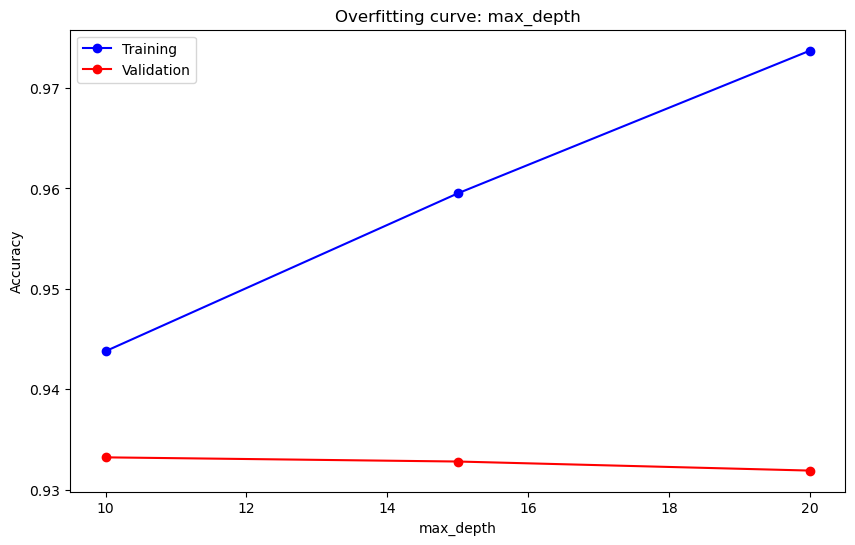

In [109]:
test_param_and_plotRF("max_depth", [10,15,20])

{'max_leaf_nodes': 64}
Model n° 0, Train accuracy: 0.9353400545011603, Validation accuracy: 0.9364762977727706
Model n° 1, Train accuracy: 0.935860030235626, Validation accuracy: 0.9344830574573186
Model n° 2, Train accuracy: 0.9360044679396443, Validation accuracy: 0.9307565646936476
Model n° 3, Train accuracy: 0.9358985469566976, Validation accuracy: 0.9324031545194558
Model n° 4, Train accuracy: 0.9357733676132151, Validation accuracy: 0.9333564433659762
Model n° 5, Train accuracy: 0.9353978295827676, Validation accuracy: 0.9362163099055377
Model n° 6, Train accuracy: 0.9358889177764297, Validation accuracy: 0.9333564433659762
Model n° 7, Train accuracy: 0.935532638106518, Validation accuracy: 0.9336164312332091
Model n° 8, Train accuracy: 0.9357059633513399, Validation accuracy: 0.9343963948349077
Model n° 9, Train accuracy: 0.9359948387593764, Validation accuracy: 0.9294566253574833
Confusion Matrix for all validation folds:
 [[106580    689]
 [  6990   1131]]
Classification Repor

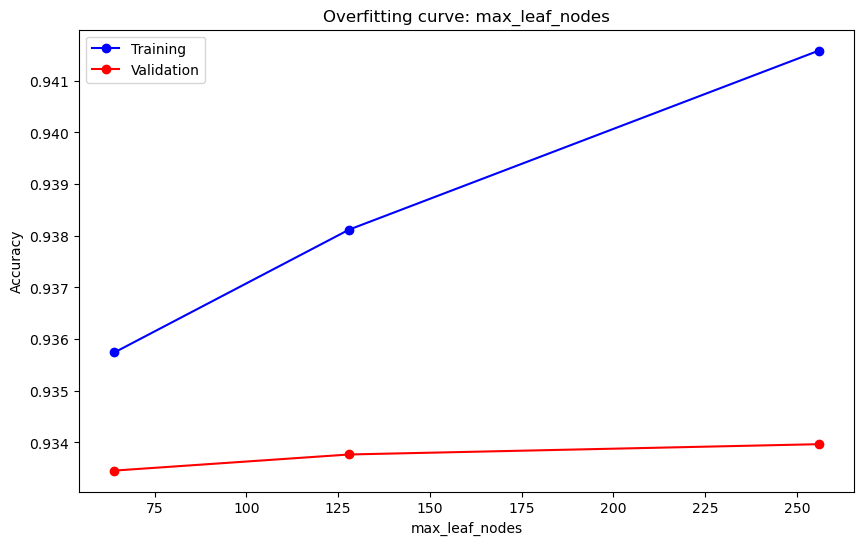

In [110]:
test_param_and_plotRF("max_leaf_nodes", [64,128,256])

{'min_weight_fraction_leaf': 0.042}
Model n° 0, Train accuracy: 0.9291677499494468, Validation accuracy: 0.9337030938556201
Model n° 1, Train accuracy: 0.9294277378166796, Validation accuracy: 0.9313632030505243
Model n° 2, Train accuracy: 0.9299573427314133, Validation accuracy: 0.9265967588179218
Model n° 3, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 4, Train accuracy: 0.92956254634043, Validation accuracy: 0.930149926336771
Model n° 5, Train accuracy: 0.9292158958507862, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 7, Train accuracy: 0.929735871585252, Validation accuracy: 0.9285899991333738
Model n° 8, Train accuracy: 0.9295529171601622, Validation accuracy: 0.9302365889591819
Model n° 9, Train accuracy: 0.9300440053538243, Validation accuracy: 0.9258167952162233
Confusion Matrix for all validation folds:
 [[107269      0]
 [  8121      0]]


C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for all validation folds:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96    107269
           1       0.00      0.00      0.00      8121

    accuracy                           0.93    115390
   macro avg       0.46      0.50      0.48    115390
weighted avg       0.86      0.93      0.90    115390

{'min_weight_fraction_leaf': 0.045}
Model n° 0, Train accuracy: 0.9291677499494468, Validation accuracy: 0.9337030938556201
Model n° 1, Train accuracy: 0.9294277378166796, Validation accuracy: 0.9313632030505243
Model n° 2, Train accuracy: 0.9299573427314133, Validation accuracy: 0.9265967588179218
Model n° 3, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 4, Train accuracy: 0.92956254634043, Validation accuracy: 0.930149926336771
Model n° 5, Train accuracy: 0.9292158958507862, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9297743883063235, Validation accu

C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for all validation folds:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96    107269
           1       0.00      0.00      0.00      8121

    accuracy                           0.93    115390
   macro avg       0.46      0.50      0.48    115390
weighted avg       0.86      0.93      0.90    115390

{'min_weight_fraction_leaf': 0.048}
Model n° 0, Train accuracy: 0.9291677499494468, Validation accuracy: 0.9337030938556201
Model n° 1, Train accuracy: 0.9294277378166796, Validation accuracy: 0.9313632030505243
Model n° 2, Train accuracy: 0.9299573427314133, Validation accuracy: 0.9265967588179218
Model n° 3, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 4, Train accuracy: 0.92956254634043, Validation accuracy: 0.930149926336771
Model n° 5, Train accuracy: 0.9292158958507862, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9297743883063235, Validation accu

C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for all validation folds:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96    107269
           1       0.00      0.00      0.00      8121

    accuracy                           0.93    115390
   macro avg       0.46      0.50      0.48    115390
weighted avg       0.86      0.93      0.90    115390



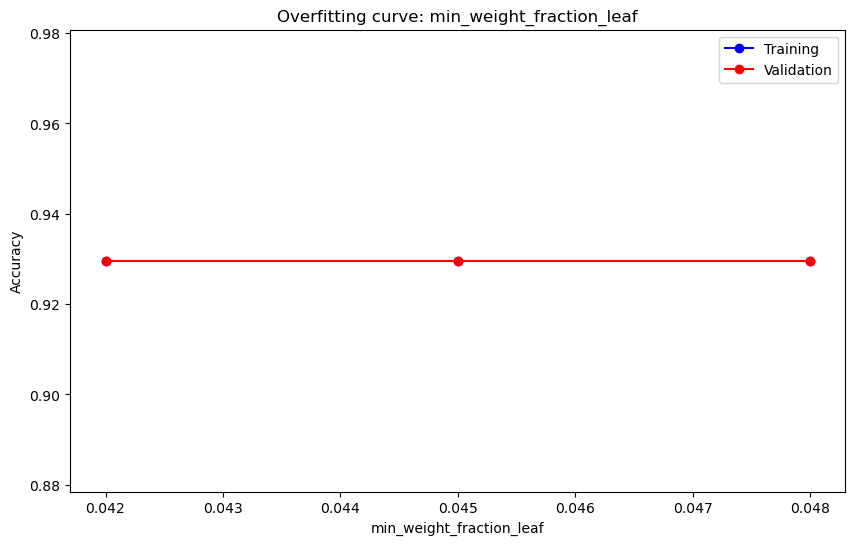

In [111]:
test_param_and_plotRF("min_weight_fraction_leaf", [0.042,0.045,0.048])

In [112]:
test_and_showRF(inputs, max_depth=10, max_leaf_nodes=128, min_weight_fraction_leaf=0.04)

Model n° 0, Train accuracy: 0.9291677499494468, Validation accuracy: 0.9337030938556201
Model n° 1, Train accuracy: 0.9294277378166796, Validation accuracy: 0.9313632030505243
Model n° 2, Train accuracy: 0.9299573427314133, Validation accuracy: 0.9265967588179218
Model n° 3, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 4, Train accuracy: 0.92956254634043, Validation accuracy: 0.930149926336771
Model n° 5, Train accuracy: 0.9292158958507862, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 7, Train accuracy: 0.929735871585252, Validation accuracy: 0.9285899991333738
Model n° 8, Train accuracy: 0.9295529171601622, Validation accuracy: 0.9302365889591819
Model n° 9, Train accuracy: 0.9300440053538243, Validation accuracy: 0.9258167952162233
Confusion Matrix for all validation folds:
 [[107269      0]
 [  8121      0]]
Classification Report for all validation fold

C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([RandomForestClassifier(max_depth=10, max_leaf_nodes=128,
                         min_weight_fraction_leaf=0.04, n_jobs=-1,
                         random_state=42),
  RandomForestClassifier(max_depth=10, max_leaf_nodes=128,
                         min_weight_fraction_leaf=0.04, n_jobs=-1,
                         random_state=42),
  RandomForestClassifier(max_depth=10, max_leaf_nodes=128,
                         min_weight_fraction_leaf=0.04, n_jobs=-1,
                         random_state=42),
  RandomForestClassifier(max_depth=10, max_leaf_nodes=128,
                         min_weight_fraction_leaf=0.04, n_jobs=-1,
                         random_state=42),
  RandomForestClassifier(max_depth=10, max_leaf_nodes=128,
                         min_weight_fraction_leaf=0.04, n_jobs=-1,
                         random_state=42),
  RandomForestClassifier(max_depth=10, max_leaf_nodes=128,
                         min_weight_fraction_leaf=0.04, n_jobs=-1,
                         rand

In [113]:
modelRF, train_accRF, valid_accRF = test_and_showRF(inputs, max_depth=8, max_leaf_nodes=128, min_weight_fraction_leaf=0.04)

Model n° 0, Train accuracy: 0.9291677499494468, Validation accuracy: 0.9337030938556201
Model n° 1, Train accuracy: 0.9294277378166796, Validation accuracy: 0.9313632030505243
Model n° 2, Train accuracy: 0.9299573427314133, Validation accuracy: 0.9265967588179218
Model n° 3, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 4, Train accuracy: 0.92956254634043, Validation accuracy: 0.930149926336771
Model n° 5, Train accuracy: 0.9292158958507862, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9297743883063235, Validation accuracy: 0.9282433486437299
Model n° 7, Train accuracy: 0.929735871585252, Validation accuracy: 0.9285899991333738
Model n° 8, Train accuracy: 0.9295529171601622, Validation accuracy: 0.9302365889591819
Model n° 9, Train accuracy: 0.9300440053538243, Validation accuracy: 0.9258167952162233
Confusion Matrix for all validation folds:
 [[107269      0]
 [  8121      0]]
Classification Report for all validation fold

C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
# Feature scaling: normalization

In [115]:
inputs_col = inputs.columns

scaler = preprocessing.MinMaxScaler().fit(train_data[train_data.columns[:-1] ])
inputs[inputs_col] = scaler.transform(inputs[inputs_col])
inputs

C:\Users\inesm\AppData\Local\Temp\ipykernel_4612\1456316352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs[inputs_col] = scaler.transform(inputs[inputs_col])


,monthly_income,debt_ratio,nr_dependents,credit_balances_dividedby_limits,nr_open_credit_lines_and_loans,nr_real_estate_loans,nr_times_30_59_days_past_due,nr_times_60_89_days_past_due,nr_times_90plus_days_past_due
0,0.000038,2.142472e-12,0.0050,9.040993e-10,0.003864,0.002058,0.000208,0.0,0.000000
1,0.000011,3.213708e-13,0.0025,1.129526e-09,0.001189,0.000000,0.000000,0.0,0.000000
2,0.000013,2.410281e-13,0.0000,7.767126e-10,0.000595,0.000000,0.000104,0.0,0.000104
3,0.000014,1.071236e-13,0.0000,2.759169e-10,0.001486,0.000000,0.000000,0.0,0.000000
5,0.000015,1.017674e-12,0.0025,2.515703e-10,0.000892,0.000343,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
149994,0.000014,1.071236e-12,0.0000,4.552111e-10,0.002081,0.000000,0.000000,0.0,0.000000
149995,0.000009,6.159607e-13,0.0000,4.799887e-11,0.001189,0.000343,0.000000,0.0,0.000000
149996,0.000023,1.928225e-12,0.0050,3.537266e-10,0.001189,0.000343,0.000000,0.0,0.000000
149998,0.000024,0.000000e+00,0.0000,0.000000e+00,0.001189,0.000000,0.000000,0.0,0.000000


{'max_iter': 10}
Model n° 0, Train accuracy: 0.9293699627350723, Validation accuracy: 0.9337030938556201
Model n° 1, Train accuracy: 0.9296203214220373, Validation accuracy: 0.9314498656729353
Model n° 2, Train accuracy: 0.9301691846973067, Validation accuracy: 0.9265100961955108
Model n° 3, Train accuracy: 0.9299573427314133, Validation accuracy: 0.9284166738885519
Model n° 4, Train accuracy: 0.9297455007655199, Validation accuracy: 0.9303232515815929
Model n° 5, Train accuracy: 0.9294181086364118, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9299573427314133, Validation accuracy: 0.9284166738885519
Model n° 7, Train accuracy: 0.929889938469538, Validation accuracy: 0.9290233122454286
Model n° 8, Train accuracy: 0.9296877256839126, Validation accuracy: 0.9308432273160586
Model n° 9, Train accuracy: 0.9302173305986461, Validation accuracy: 0.9260767830834561
{'max_iter': 50}
Model n° 0, Train accuracy: 0.9293699627350723, Validation accuracy: 0.9336164312332091

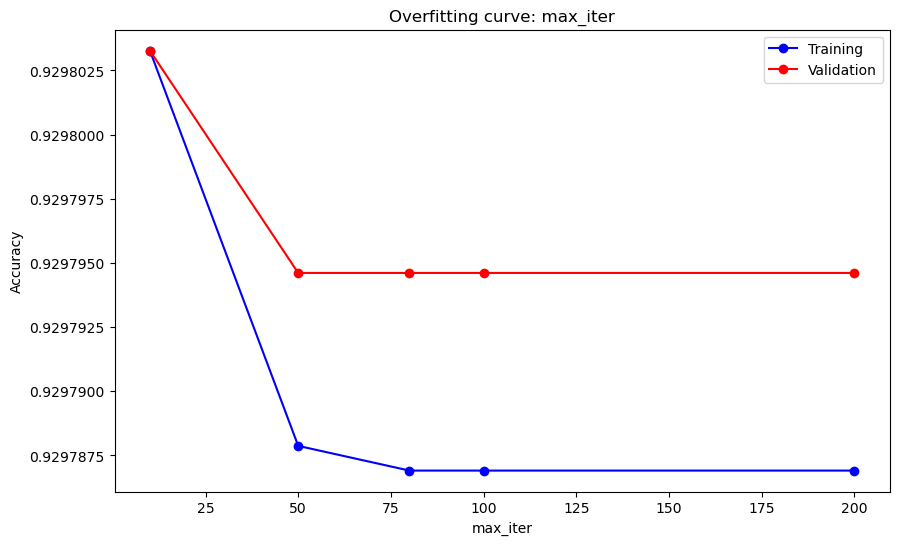

In [89]:
test_param_and_plotLR(inputs, "max_iter", [10,50,80,100,200])

{'fit_intercept': True}
Model n° 0, Train accuracy: 0.9293603335548045, Validation accuracy: 0.9336164312332091
Model n° 1, Train accuracy: 0.9296010630615016, Validation accuracy: 0.9314498656729353
Model n° 2, Train accuracy: 0.930149926336771, Validation accuracy: 0.9265100961955108
Model n° 3, Train accuracy: 0.9299380843708775, Validation accuracy: 0.9284166738885519
Model n° 4, Train accuracy: 0.929726242404984, Validation accuracy: 0.9303232515815929
Model n° 5, Train accuracy: 0.929398850275876, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9299380843708775, Validation accuracy: 0.9284166738885519
Model n° 7, Train accuracy: 0.9298803092892702, Validation accuracy: 0.9290233122454286
Model n° 8, Train accuracy: 0.9296780965036446, Validation accuracy: 0.9308432273160586
Model n° 9, Train accuracy: 0.9301980722381104, Validation accuracy: 0.9260767830834561
{'fit_intercept': False}
Model n° 0, Train accuracy: 0.9292255250310542, Validation accuracy: 0.933

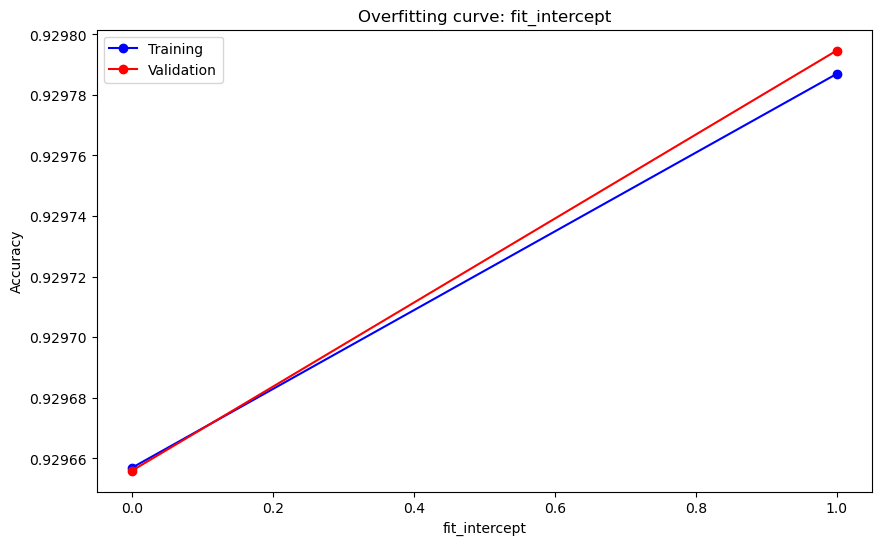

In [90]:
test_param_and_plotLR(inputs, "fit_intercept", [True, False])

In [91]:
modelLR, train_accLR, val_accLR = test_and_showLR(inputs, max_iter=80, fit_intercept=True)

Model n° 0, Train accuracy: 0.9293603335548045, Validation accuracy: 0.9336164312332091
Model n° 1, Train accuracy: 0.9296010630615016, Validation accuracy: 0.9314498656729353
Model n° 2, Train accuracy: 0.930149926336771, Validation accuracy: 0.9265100961955108
Model n° 3, Train accuracy: 0.9299380843708775, Validation accuracy: 0.9284166738885519
Model n° 4, Train accuracy: 0.929726242404984, Validation accuracy: 0.9303232515815929
Model n° 5, Train accuracy: 0.929398850275876, Validation accuracy: 0.9332697807435653
Model n° 6, Train accuracy: 0.9299380843708775, Validation accuracy: 0.9284166738885519
Model n° 7, Train accuracy: 0.9298803092892702, Validation accuracy: 0.9290233122454286
Model n° 8, Train accuracy: 0.9296780965036446, Validation accuracy: 0.9308432273160586
Model n° 9, Train accuracy: 0.9301980722381104, Validation accuracy: 0.9260767830834561


In [92]:
modelLR[5], train_accLR, val_accLR

(LogisticRegression(max_iter=80, n_jobs=-1, random_state=42),
 0.9297869062406716,
 0.9297946095848859)

In [116]:
modelRF[0], train_accRF, valid_accRF

(RandomForestClassifier(max_depth=8, max_leaf_nodes=128,
                        min_weight_fraction_leaf=0.04, n_jobs=-1,
                        random_state=42),
 0.9296212843400642,
 0.9296212843400641)

# another attempt 

In [7]:
# Drop the target column from X
X = dataset.drop('serious_delinquency', axis=1)
Y = dataset['serious_delinquency']

# Splitting the data into training and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size = 0.30, random_state = 0)
X_train_wo_sampling = X_train
y_train_wo_sampling = y_train

In [8]:
# Creating more samples units for the bankrupt companies(undersampled data)
y_train = (np.matrix(y_train)).T
y_train = pd.DataFrame(y_train)
y_train.columns = ["serious_deliquency"]
X_train = pd.DataFrame(X_train)
frame = [X_train,y_train]
train_data = pd.concat(frame,axis = 1)
bankrupt_companies = train_data[train_data.serious_deliquency == 1]

feat_mat = bankrupt_companies.iloc[:,:-1].values
response = bankrupt_companies.iloc[:,-1].values
col_mean = np.zeros(shape=(82,1)) 
col_std = np.zeros(shape=(82,1)) 
Dim_1 = np.shape(feat_mat)
for i in range(0,Dim_1[1]): # Logic to calculate mean and standard deviation for each column
       col_mean[i,0] = np.mean(feat_mat[:,i])
       col_std[i,0] = np.std(feat_mat[:,i])
col_mean_and_std = np.hstack((col_mean,col_std))

added_data = np.zeros(shape=(1200,Dim_1[1])) 
for i in range (0,-len(col_mean_and_std)):
       mean_ = col_mean_and_std[i,0]
       std_ = col_mean_and_std[i,1]
       added_data[:,i] = np.random.normal(mean_,std_,1200)
added_y = np.ones(shape=(1200,1)) # Creating labels for the added data

X_resampled = np.vstack((X_train,added_data)) # Combining the original data + added data
y_train = np.array(y_train)
y_resampled = np.vstack((y_train,added_y))

In [9]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_resampled = sc.fit_transform(X_resampled)
X_test = sc.transform(X_test)

C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [10]:
# Fitting XGBClassifier to the training data: Model_1
from xgboost import XGBClassifier
classifier_1 = XGBClassifier()
classifier_1.fit(X_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
# Fitting SVM to the training data: Model 2
classifier_2 = SVC(kernel = 'linear', C = 1, probability = True, random_state = 2) # poly, sigmoid
classifier_2.fit(X_resampled, y_resampled)

C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear', probability=True, random_state=2)

In [12]:
# Creating and Fitting Random Forest Classifier to the training data: Model 3
from sklearn.ensemble import RandomForestClassifier
classifier_3 = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')
classifier_3.fit(X_resampled, y_resampled)

C:\Users\inesm\AppData\Local\Temp\ipykernel_21764\168599509.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier_3.fit(X_resampled, y_resampled)


RandomForestClassifier(criterion='entropy', n_estimators=5)

In [16]:
# Fitting classifier to the training data: Model 4 
from sklearn.linear_model import LogisticRegression
classifier_4 = LogisticRegression(penalty = 'l1', solver='saga',random_state = 0)
classifier_4.fit(X_resampled, y_resampled)


C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', random_state=0, solver='saga')

In [61]:

# Fitting Decision Tree to the training data: Model 5
from sklearn.tree import DecisionTreeClassifier
classifier_5 = DecisionTreeClassifier()
classifier_5.fit(X_resampled,y_resampled)


DecisionTreeClassifier()

In [62]:
# Fitting Naive Bayes to the training data: Model 6
from sklearn.naive_bayes import GaussianNB
classifier_6 = GaussianNB()
classifier_6.fit(X_resampled,y_resampled)

C:\Users\inesm\anaconda3\envs\NN\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [63]:
# Predicting the results
y_pred_1 = classifier_1.predict(X_test)
y_pred_2 = classifier_2.predict(X_test)
y_pred_3 = classifier_3.predict(X_test)
y_pred_4 = classifier_4.predict(X_test)
y_pred_5 = classifier_5.predict(X_test)
y_pred_6 = classifier_6.predict(X_test)
# y_pred_7 = classifier_7.predict(X_test)

# Creating the confusion matrix
from sklearn.metrics import confusion_matrix
cm_1 = confusion_matrix(y_test,y_pred_1)
accuracy_1 = (cm_1[0,0]+cm_1[1,1])/len(y_test)

cm_2 = confusion_matrix(y_test,y_pred_2)
accuracy_2 = (cm_2[0,0]+cm_2[1,1])/len(y_test)

cm_3 = confusion_matrix(y_test,y_pred_3)
accuracy_3 = (cm_3[0,0]+cm_3[1,1])/len(y_test)

cm_4 = confusion_matrix(y_test,y_pred_4)
accuracy_4 = (cm_4[0,0]+cm_4[1,1])/len(y_test)

cm_5 = confusion_matrix(y_test,y_pred_5)
accuracy_5 = (cm_5[0,0]+cm_5[1,1])/len(y_test)

cm_6 = confusion_matrix(y_test,y_pred_6)
accuracy_6 = (cm_6[0,0]+cm_6[1,1])/len(y_test)

# cm_7 = confusion_matrix(y_test,y_pred_7)
# accuracy_7 = (cm_7[0,0]+cm_7[1,1])/len(y_test)

In [64]:
from sklearn.metrics import precision_recall_fscore_support
precision_1, recall_1, f_score_1, support = precision_recall_fscore_support(y_test, y_pred_1, average = None)
print("\nFor Model 1 - XGBoost:")
print("Precision:",precision_1)
print("Recall:",recall_1)
print("F-Score:",f_score_1)
print("Accuracy_XGBoost:",accuracy_1*100,'%')

precision_2, recall_2, f_score_2, support = precision_recall_fscore_support(y_test, y_pred_2, average = None)
print("\nFor Model 2 - SVC:")
print("Precision:",precision_2)
print("Recall:",recall_2)
print("F-Score:",f_score_2)
print("Accuracy_SVC:",accuracy_2*100,'%') 

precision_3, recall_3, f_score_3, support = precision_recall_fscore_support(y_test, y_pred_3, average = None)
print("\nFor Model 3 - Random Forest:")
print("Precision:",precision_3)
print("Recall:",recall_3)
print("F-Score:",f_score_3)
print("Accuracy_RF:",accuracy_3*100,'%') 

precision_4, recall_4, f_score_4, support = precision_recall_fscore_support(y_test, y_pred_4, average = None)
print("\nFor Model 4 - Logistic:")
print("Precision:",precision_4)
print("Recall:",recall_4)
print("F-Score:",f_score_4)
print("Accuracy_Logistic:",accuracy_4*100,'%') 

precision_5, recall_5, f_score_5, support = precision_recall_fscore_support(y_test, y_pred_5, average = None)
print("\nFor Model 5 - Decision Tree Classifier:")
print("Precision:",precision_5)
print("Recall:",recall_5)
print("F-Score:",f_score_5)
print("Accuracy_DecisionTree:",accuracy_5*100,'%') 

precision_6, recall_6, f_score_6, support = precision_recall_fscore_support(y_test, y_pred_6, average = None)
print("\nFor Model 6 - Naive Bayes Classifier:")
print("Precision:",precision_6)
print("Recall:",recall_6)
print("F-Score:",f_score_6)
print("Accuracy_NaiveBayes:",accuracy_6*100,'%')


For Model 1 - XGBoost:
Precision: [0.9432374  0.57386364]
Recall: [0.98835295 0.20867769]
F-Score: [0.9652683  0.30606061]
Accuracy_XGBoost: 93.38475315596384 %

For Model 2 - SVC:
Precision: [0.93076612 0.50943396]
Recall: [0.99919247 0.01115702]
F-Score: [0.96376627 0.02183583]
Accuracy_SVC: 93.01210387959674 %

For Model 3 - Random Forest:
Precision: [0.94405762 0.42868157]
Recall: [0.97698543 0.22975207]
F-Score: [0.96023933 0.29916599]
Accuracy_RF: 92.4747956206488 %

For Model 4 - Logistic:
Precision: [0.93124222 0.51111111]
Recall: [0.99863341 0.01900826]
F-Score: [0.96376117 0.03665339]
Accuracy_Logistic: 93.0149926336771 %

For Model 5 - Decision Tree Classifier:
Precision: [0.94585888 0.26049149]
Recall: [0.939249   0.28471074]
F-Score: [0.94254235 0.27206318]
Accuracy_DecisionTree: 89.34916370569374 %

For Model 6 - Naive Bayes Classifier:
Precision: [0.93130037 0.42016807]
Recall: [0.99785694 0.02066116]
F-Score: [0.96343054 0.03938558]
Accuracy_NaiveBayes: 92.954328797989

Text(0, 0.5, 'ACCURACY')

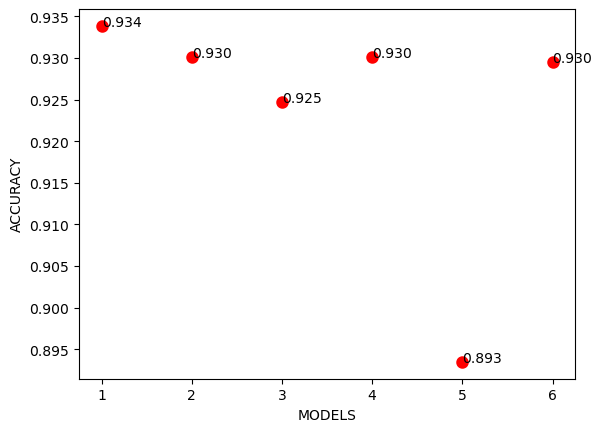

In [65]:
# Comparing the Accuracies of various models
ACCURACY = np.vstack((accuracy_1,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6))

number = np.array([1,2,3,4,5,6])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(number, ACCURACY, color = 'r', marker = 'o', linewidths = 3)
for j in range(0,len(ACCURACY)):
       ax.annotate('%0.3f' % (ACCURACY[j]),(number[j], ACCURACY[j]))

plt.xlabel('MODELS')    
plt.ylabel('ACCURACY')

Text(0, 0.5, 'F-SCORE')

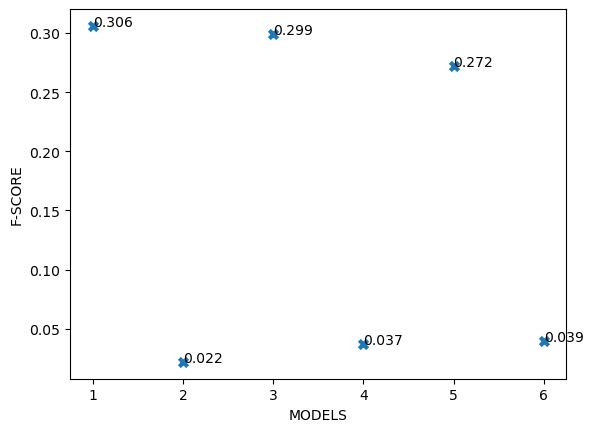

In [66]:
# Comparing the F-Values of various models
F_SCORE = np.vstack((f_score_1[1],f_score_2[1],f_score_3[1],f_score_4[1],f_score_5[1],f_score_6[1]))

number = np.array([1,2,3,4,5,6])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(number, F_SCORE, marker = 'x', linewidths = 3)
for i in range(0,len(F_SCORE)):
       ax.annotate('%0.3f' % (F_SCORE[i]),(number[i], F_SCORE[i]))

plt.xlabel('MODELS')    
plt.ylabel('F-SCORE')


C:\Users\inesm\AppData\Local\Temp\ipykernel_21764\747239129.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\inesm\AppData\Local\Temp\ipykernel_21764\747239129.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\inesm\AppData\Local\Temp\ipykernel_21764\747239129.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\inesm\AppData\Local\Temp\ipykernel_21764\747239129.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\inesm\AppData\Local\Temp\ipykernel_21764\747239129.py:37: DeprecationWarning: scipy.interp is deprecated and will be remove

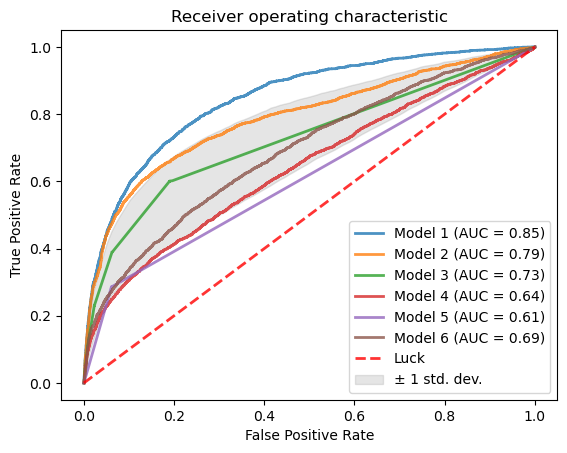

In [70]:

# Initialize the lists to store true positive rates (tprs) and AUC values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0

# Predict probabilities for the test set using each classifier
probas_1 = classifier_1.predict_proba(X_test)
probas_2 = classifier_2.predict_proba(X_test)
probas_3 = classifier_3.predict_proba(X_test)
probas_4 = classifier_4.predict_proba(X_test)
probas_5 = classifier_5.predict_proba(X_test)
probas_6 = classifier_6.predict_proba(X_test)

# Stack the predicted probabilities vertically
probas = np.vstack((probas_1, probas_2, probas_3, probas_4, probas_5, probas_6))

# Ensure the pointers are correctly aligned with the number of samples
n_samples = len(y_test)
pointer = np.arange(0, n_samples * 6 + 1, n_samples)

# Compute ROC curve and area under the curve for each classifier
for a in range(6):
    index_1 = pointer[a]
    index_2 = pointer[a + 1]
    
    # Check if the indices are valid
    if index_2 > len(probas):
        index_2 = len(probas)
        
    fpr, tpr, thresholds = roc_curve(y_test, probas[index_1:index_2, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.8, label='Model %d (AUC = %0.2f)' % (a + 1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='± 1 std. dev.')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Investigating various sampling techniques

In [77]:
# Testing various oversampling techniques
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Random Oversampler
ros = RandomOverSampler(random_state=0)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled_ros).items()))

# Synthetic Minority Oversampling Technique(SMOTE) 
X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled_smote).items()))

# Adaptive Synthetic (ADASYN) sampling method
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled_adasyn).items()))

[(0, 75072), (1, 75072)]
[(0, 75072), (1, 75072)]
[(0, 75072), (1, 74032)]


In [78]:
# Feature scaling
X_resampled_ros = sc.fit_transform(X_resampled_ros)
X_resampled_smote = sc.fit_transform(X_resampled_smote)
X_resampled_adasyn = sc.fit_transform(X_resampled_adasyn)
X_train_wo_sampling = sc.fit_transform(X_train_wo_sampling)

#  Random Forest:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.91     26808
           1       0.23      0.56      0.32      2040

    accuracy                           0.83     28848
   macro avg       0.59      0.71      0.61     28848
weighted avg       0.91      0.83      0.86     28848

Confusion Matrix before threshold improvement:
[[22892  3916]
 [  888  1152]]
Accuracy Score:
0.8334719911259013
Best threshold: 0.58
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     26808
           1       0.26      0.49      0.34      2040

    accuracy                           0.86     28848
   macro avg       0.61      0.69      0.63     28848
weighted avg       0.91      0.86      0.88     28848

Confusion Matrix with Custom Threshold:
[[23906  2902]
 [ 1039  1001]]
Accuracy Score with Custom Threshold:
0.8633874098724348


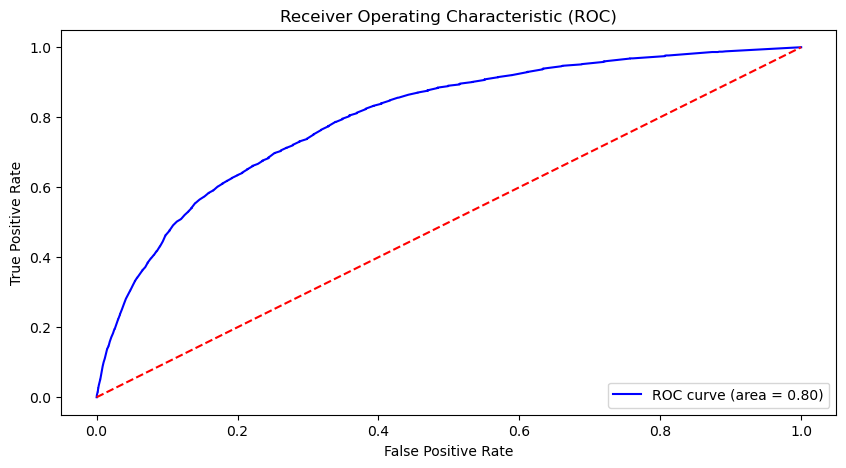

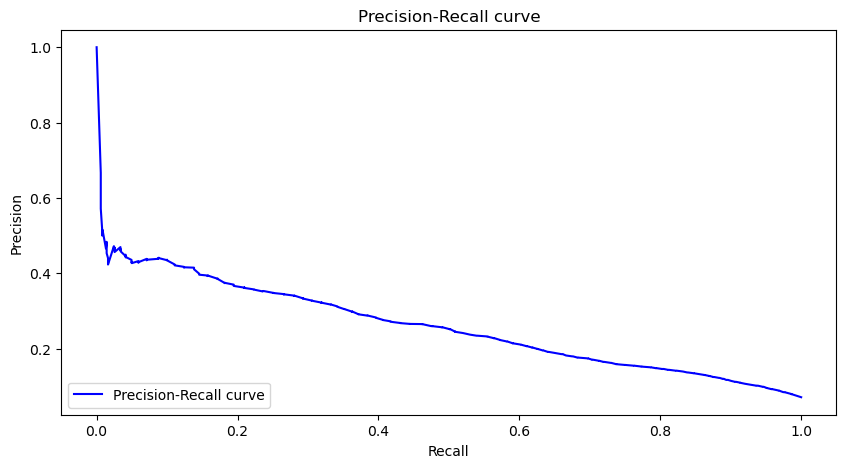

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     26808
           1       0.22      0.51      0.31      2040

    accuracy                           0.84     28848
   macro avg       0.59      0.69      0.61     28848
weighted avg       0.91      0.84      0.87     28848

Confusion Matrix with Tuned Model:
[[23165  3643]
 [  992  1048]]
Accuracy Score with Tuned Model:
0.8393302828618968


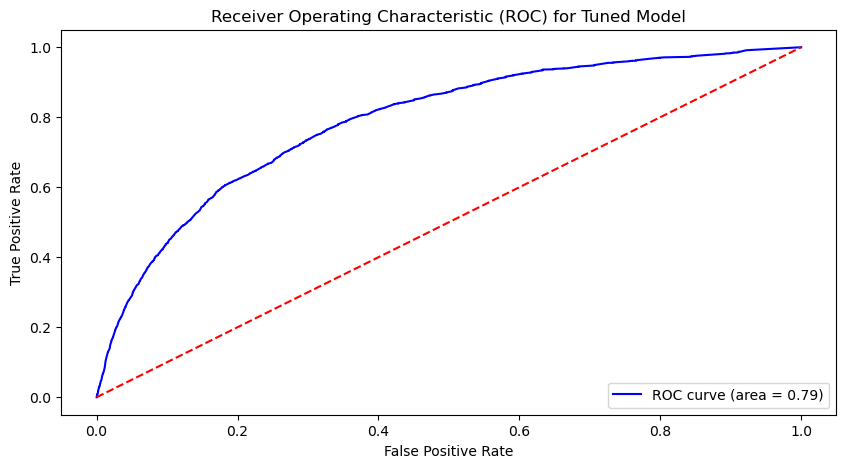

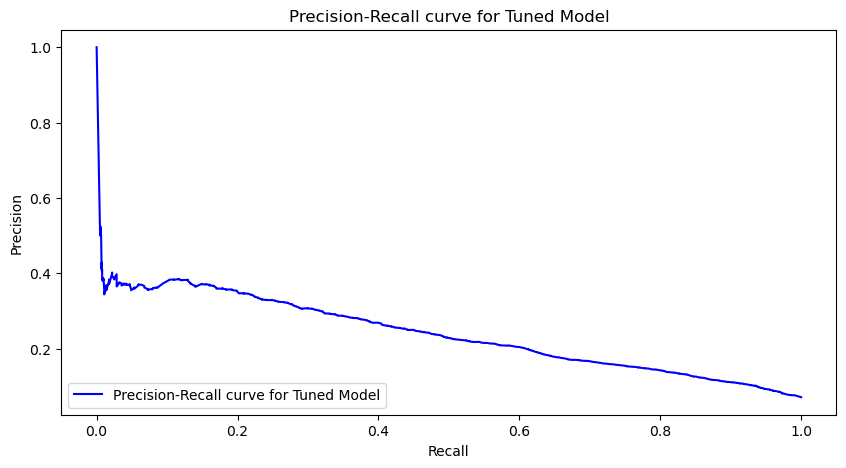

In [8]:
# Drop the target column from X
X = dataset.drop('serious_delinquency', axis=1)
y = dataset['serious_delinquency']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Standardize features using StandardScaler
ss = StandardScaler()
X_train_res = ss.fit_transform(X_train_res)
X_test = ss.transform(X_test)

# Initialize Random Forest model
# rf_model = RandomForestClassifier(class_weight='balanced', random_state=0)
rf_model = RandomForestClassifier(class_weight={0: 1.0, 1: 5.0}, random_state=0)

# Fit the model on the resampled training data
rf_model.fit(X_train_res, y_train_res)

# Predictions
y_pred = rf_model.predict(X_test)

# Interested in the probabilities of the positive class (class 1)
y_scores = rf_model.predict_proba(X_test)[:, 1]

# Model evaluation before threshold adjustment
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix before threshold improvement:')
print(confusion_matrix(y_test, y_pred))

print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

# Simulate prediction probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the best threshold based on F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'Best threshold: {best_threshold:.2f}')

# Apply the custom threshold to get the predicted classes
y_pred_custom = (y_scores >= best_threshold).astype(int)

# Evaluate the model with the custom threshold
print('Classification Report with Custom Threshold:')
print(classification_report(y_test, y_pred_custom))

print('Confusion Matrix with Custom Threshold:')
print(confusion_matrix(y_test, y_pred_custom))

print('Accuracy Score with Custom Threshold:')
print(accuracy_score(y_test, y_pred_custom))

# ROC and Precision-Recall curves to evaluate the model
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 5))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
#     , 300],
    'max_depth': [None, 10],
#     , 20, 30],
    'min_samples_split': [2, 5],
#     , 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)

print("Best parameters found: ", grid_search.best_params_)

# Train the best model
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_res, y_train_res)

# Predictions with the best model
y_pred_best = best_rf_model.predict(X_test)
y_scores_best = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_best))

print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_best))

print('Accuracy Score with Tuned Model:')
print(accuracy_score(y_test, y_pred_best))

# ROC and Precision-Recall curves for the tuned model
fpr_best, tpr_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 5))
plt.plot(fpr_best, tpr_best, color='blue', label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Tuned Model')
plt.legend(loc='lower right')
plt.show()

precision_best, recall_best, _ = precision_recall_curve(y_test, y_scores_best)

plt.figure(figsize=(10, 5))
plt.plot(recall_best, precision_best, color='blue', label='Precision-Recall curve for Tuned Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Tuned Model')
plt.legend(loc='lower left')
plt.show()


# TRYING TO FURTHER IMPROVE THE RF

In [ ]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features using StandardScaler
ss = StandardScaler()
X_train_res = ss.fit_transform(X_train_res)
X_test = ss.transform(X_test)

# Initialize Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=0)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_res, y_train_res)

print("Best parameters found: ", random_search.best_params_)

# Train the best model
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_res, y_train_res)

# Predictions with the best model
y_pred_best = best_rf_model.predict(X_test)
y_scores_best = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_best))

print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_best))

print('Accuracy Score with Tuned Model:')
print(accuracy_score(y_test, y_pred_best))

# ROC and Precision-Recall curves for the tuned model
fpr_best, tpr_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 5))
plt.plot(fpr_best, tpr_best, color='blue', label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Tuned Model')
plt.legend(loc='lower right')
plt.show()

precision_best, recall_best, _ = precision_recall_curve(y_test, y_scores_best)

plt.figure(figsize=(10, 5))
plt.plot(recall_best, precision_best, color='blue', label='Precision-Recall curve for Tuned Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Tuned Model')
plt.legend(loc='lower left')
plt.show()


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Standardize features using StandardScaler
ss = StandardScaler()
X_train_res = ss.fit_transform(X_train_res)
X_test = ss.transform(X_test)

# Initialize Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=0)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_res, y_train_res)

print("Best parameters found: ", random_search.best_params_)

# Train the best model
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_res, y_train_res)

# Predictions with the best model
y_pred_best = best_rf_model.predict(X_test)
y_scores_best = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_best))

print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_best))

print('Accuracy Score with Tuned Model:')
print(accuracy_score(y_test, y_pred_best))

# ROC and Precision-Recall curves for the tuned model
fpr_best, tpr_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 5))
plt.plot(fpr_best, tpr_best, color='blue', label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Tuned Model')
plt.legend(loc='lower right')
plt.show()

precision_best, recall_best, _ = precision_recall_curve(y_test, y_scores_best)

plt.figure(figsize=(10, 5))
plt.plot(recall_best, precision_best, color='blue', label='Precision-Recall curve for Tuned Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Tuned Model')
plt.legend(loc='lower left')
plt.show()
